We will use [tsfresh](https://tsfresh.readthedocs.io/) to create features. The module takes flat dataframes, as described [in the docs](https://tsfresh.readthedocs.io/en/latest/text/data_formats.html).

We will take the UC Berkeley milling data set and create a flat dataframe from it.

In [1]:
import pathlib
from pathlib import Path
import scipy.io as sio
import numpy as np
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%load_ext autoreload
%autoreload 2

Set folder paths.

In [2]:
root_dir = Path.cwd().parent
print(root_dir)

folder_raw_data_milling = root_dir / 'data/raw/milling'
folder_processed_data_milling = root_dir / 'data/processed/milling'
print(folder_raw_data_milling)

c:\_Python\feat-store
c:\_Python\feat-store\data\raw\milling


In [3]:
# extract mill.zip if not already extracted
data_path = folder_raw_data_milling / 'mill.mat'
if not data_path.exists():
    with zipfile.ZipFile(folder_raw_data_milling / 'mill.zip', 'r') as zip_ref:
        zip_ref.extractall(folder_raw_data_milling)

In [4]:
# load the data from the matlab file
m = sio.loadmat(data_path, struct_as_record=True)

# store the 'mill' data in a seperate np array
data = m['mill']


Get an idea of the stucture of the data array.

In [5]:
# show some of the info from the matlab file
print('Keys in the matlab dict file: \n', m.keys(), '\n')

# store the field names in the data np array in a tuple, l
l = data.dtype.names
print('List of the field names:\n',l)

Keys in the matlab dict file: 
 dict_keys(['__header__', '__version__', '__globals__', 'mill']) 

List of the field names:
 ('case', 'run', 'VB', 'time', 'DOC', 'feed', 'material', 'smcAC', 'smcDC', 'vib_table', 'vib_spindle', 'AE_table', 'AE_spindle')


In [6]:
data['time'].shape

(1, 167)

In [7]:
# store the field names in the data np array in a tuple, l
l = data.dtype.names

# create empty dataframe for the labels
df_labels = pd.DataFrame()

# get the labels from the original .mat file and put in dataframe
for i in range(7):
    # list for storing the label data for each field
    x = []
    
    # iterate through each of the unique cuts
    for j in range(167):
        x.append(data[0,j][i][0][0])
    x = np.array(x)
    df_labels[str(i)] = x

# add column names to the dataframe
df_labels.columns = l[0:7]
    
# create a column with the unique cut number
df_labels['cut_no'] = [i for i in range(167)]

df_labels.head()

,case,run,VB,time,DOC,feed,material,cut_no
0,1,1,0.00,2,1.5,0.5,1,0
1,1,2,NaN,4,1.5,0.5,1,1
2,1,3,NaN,6,1.5,0.5,1,2
3,1,4,0.11,7,1.5,0.5,1,3
4,1,5,NaN,11,1.5,0.5,1,4


Make a simple plot to look at some of the data.

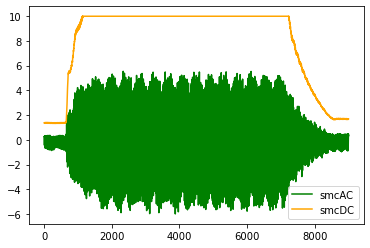

In [8]:
# look at cut number 167 (index 166)
fig, ax = plt.subplots()

ax.plot(data[0,166]['smcAC'],'g-',label='smcAC')
ax.plot(data[0,166]['smcDC'],color='orange',label='smcDC')

plt.legend()

# Create a Milling Data Prep Class
Borrow shamelessly from previous work at [ml-tool-wear](https://github.com/tvhahn/ml-tool-wear).

tsfresh likes a dataframe, but deep learning models, like those build in PyTorch, like to work with arrays. Our class will create the numpy array first, and then produce a flat dataframe from that.

In [9]:
m = sio.loadmat(data_path, struct_as_record=True)

# store the 'mill' data in a seperate np array
data = m['mill']

signal_names = data.dtype.names
signal_names = signal_names[7:][::-1]
print(signal_names)


('AE_spindle', 'AE_table', 'vib_spindle', 'vib_table', 'smcDC', 'smcAC')


In [10]:
cut_index = 97
c = data[0, cut_index][signal_names[0]].reshape((9000, 1))
c.shape

(9000, 1)

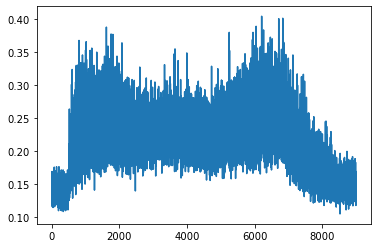

In [11]:
plt.plot(c)

In [12]:
# create a numpy array of each signal, 
# with a final array shape like [no. cuts, len cuts, no. signals]
cut_no = 145
cut = data[0, cut_no]


for i, signal_name in enumerate(signal_names):
    if i == 0:
        cut_array = cut[signal_name].reshape((9000, 1))
    else:
        cut_array = np.concatenate((cut_array, cut[signal_name].reshape((9000, 1))), axis=1)



In [13]:
cut_array.shape

(9000, 6)

In [14]:
def plot_cut(cut_signal):

    # define colour palette and seaborn style
    pal = sns.cubehelix_palette(6, rot=-0.25, light=0.7)
    sns.set(style="white", context="notebook")

    fig, axes = plt.subplots(
        6, 1, dpi=150, figsize=(5, 6), sharex=True, constrained_layout=True,
    )

    # the "revised" signal names so it looks good on the chart
    signal_names_revised = [
        "AE Spindle",
        "AE Table",
        "Vibe Spindle",
        "Vibe Table",
        "DC Current",
        "AC Current",
    ]

    # go through each of the signals
    for i in range(6):
        # plot the signal
        # note, we take the length of the signal (9000 data point)
        # and divide it by the frequency (250 Hz) to get the x-axis
        # into seconds
        axes[i].plot(np.arange(0,cut_signal.shape[0])/250.0, 
                     cut_signal[:,i], 
                     color=pal[i], 
                     linewidth=0.5, 
                     alpha=1)
        
        axis_label = signal_names_revised[i]
        
        axes[i].set_ylabel(
            axis_label, fontsize=7,
        )

        # if it's not the last signal on the plot
        # we don't want to show the subplot outlines
        if i != 5:
            axes[i].spines["top"].set_visible(False)
            axes[i].spines["right"].set_visible(False)
            axes[i].spines["left"].set_visible(False)
            axes[i].spines["bottom"].set_visible(False)
            axes[i].set_yticks([]) # also remove the y-ticks, cause ugly
        
        # for the last signal we will show the x-axis labels
        # which are the length (in seconds) of the signal
        else:
            axes[i].spines["top"].set_visible(False)
            axes[i].spines["right"].set_visible(False)
            axes[i].spines["left"].set_visible(False)
            axes[i].spines["bottom"].set_visible(False)
            axes[i].set_yticks([])
            axes[i].tick_params(axis="x", labelsize=7)
            axes[i].set_xlabel('Seconds', size=5)

    plt.show()

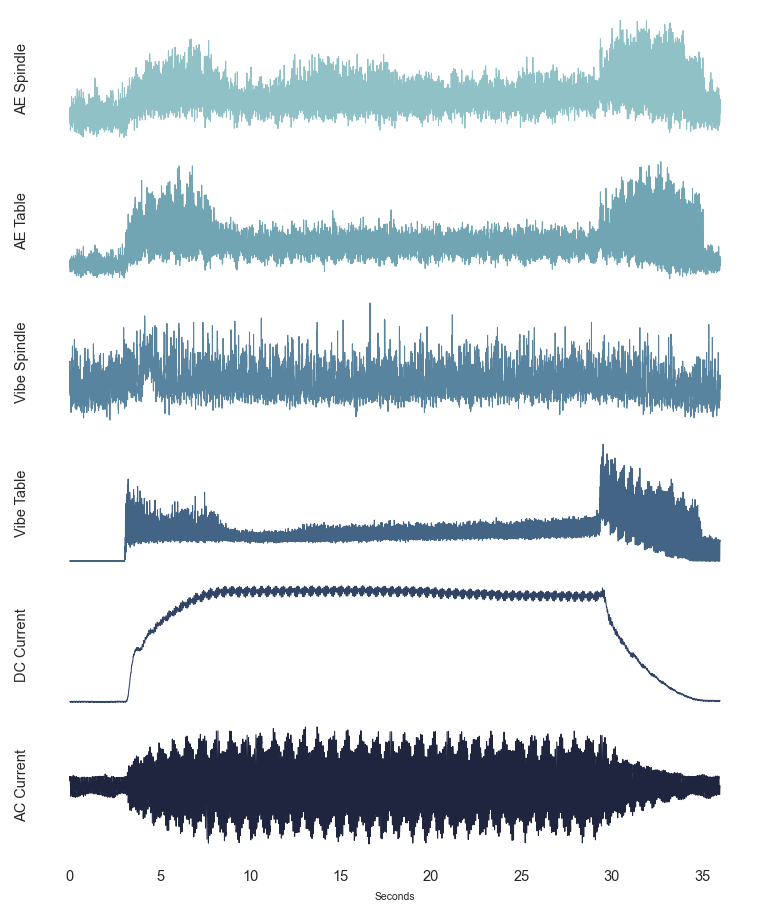

In [15]:
plot_cut(cut_array)

In [16]:
# create a numpy array of each signal, 
# with a final array shape like [no. cuts, len cuts, no. signals]
cut_no = 145
cut = data[0, cut_no]


df_labels = pd.read_csv(
    folder_processed_data_milling / "labels_with_tool_class.csv"
)

print(df_labels.columns)


for i, signal_name in enumerate(signal_names):
    if i == 0:
        cut_array = cut[signal_name].reshape((9000, 1))
    else:
        cut_array = np.concatenate((cut_array, cut[signal_name].reshape((9000, 1))), axis=1)

# select the start and end of the cut
start = df_labels[df_labels["cut_no"] == cut_no]["window_start"].values[0]
end = df_labels[df_labels["cut_no"] == cut_no]["window_end"].values[0]
cut_array = cut_array[start:end,:]

# reshape into a 3D tensor
# cut_array = cut_array.reshape((1, cut_array.shape[0], cut_array.shape[1]))
# cut_array.shape
# window the cut_array
window_size = 64
stride = 64

sub_cut_list = []
sub_cut_id_list = []
sub_cut_label_list = []

Index(['case', 'run', 'VB', 'time', 'DOC', 'feed', 'material', 'cut_no',
       'tool_class', 'window_start', 'window_end'],
      dtype='object')


In [17]:
label = df_labels[df_labels["cut_no"] == cut_no]["tool_class"].values[0]

# fit the strided windows into the dummy_array until the length
# of the window does not equal the proper length (better way to do this?)
print(cut_array.shape[0])
for i in range(cut_array.shape[0]):
    windowed_signal = cut_array[i * stride : i * stride + window_size]

    # if the windowed signal is the proper length, add it to the list
    if windowed_signal.shape == (window_size, 6):
        sub_cut_list.append(windowed_signal)

        # create sub_cut_id fstring to keep track of the cut_id and the window_id
        sub_cut_id_list.append(f"{cut_no}_{i}")

        # create the sub_cut_label and append it to the list
        sub_cut_label_list.append(int(label))

    else:
        break

sub_cut_array = np.array(sub_cut_list)

sub_cut_ids = np.expand_dims(np.array(sub_cut_id_list, dtype=str), axis=1)
sub_cut_ids = np.repeat(sub_cut_ids, sub_cut_array.shape[1], axis=1)

sub_cut_labels = np.expand_dims(np.array(sub_cut_label_list, dtype=int), axis=1)
sub_cut_labels = np.repeat(sub_cut_labels, sub_cut_array.shape[1], axis=1)

# take the length of the signals in the sub_cut_array
# and divide it by the frequency (250 Hz) to get the time (seconds) of each sub-cut
sub_cut_times = np.expand_dims(np.arange(0, sub_cut_array.shape[1])/250.0, axis=0)

# duplicate the sub_cut_time by the number of samples in the sub_cut_array to make it a 2D array
sub_cut_times = np.repeat(sub_cut_times, sub_cut_array.shape[0], axis = 0)

print('sub_cut_array.shape:', sub_cut_array.shape)
print('sub_cut_ids.shape:', sub_cut_ids.shape)
print('sub_cut_labels.shape:', sub_cut_labels.shape)
print('sub_cut_times.shape:', sub_cut_times.shape)


4480
sub_cut_array.shape: (70, 64, 6)
sub_cut_ids.shape: (70, 64)
sub_cut_labels.shape: (70, 64)
sub_cut_times.shape: (70, 64)


In [18]:
sub_cut_times[1,:]

array([0.   , 0.004, 0.008, 0.012, 0.016, 0.02 , 0.024, 0.028, 0.032,
       0.036, 0.04 , 0.044, 0.048, 0.052, 0.056, 0.06 , 0.064, 0.068,
       0.072, 0.076, 0.08 , 0.084, 0.088, 0.092, 0.096, 0.1  , 0.104,
       0.108, 0.112, 0.116, 0.12 , 0.124, 0.128, 0.132, 0.136, 0.14 ,
       0.144, 0.148, 0.152, 0.156, 0.16 , 0.164, 0.168, 0.172, 0.176,
       0.18 , 0.184, 0.188, 0.192, 0.196, 0.2  , 0.204, 0.208, 0.212,
       0.216, 0.22 , 0.224, 0.228, 0.232, 0.236, 0.24 , 0.244, 0.248,
       0.252])

In [19]:
folder_raw_data_milling = root_dir / 'data/raw/milling'
folder_processed_data_milling = root_dir / 'data/processed/milling'

In [21]:
class MillingDataPrep:
    def __init__(self, path_raw_data, path_df_labels=None, window_size=64, stride=64, cut_drop_list=[17, 94]):
        """Prepare the UC Berkeley Milling dataset for training.

        Parameters
        ----------
        path_raw_data : pathlib
            Path to the raw data folder.

        path_df_labels : pathlib, optional
            Path to the dataframe with the labels. If not provided, the dataframe must be created.

        window_size : int
            Size of the window to be used for the sliding window.

        stride : int
            Size of the stride to be used for the sliding window.

        cut_drop_list : list
            List of cut numbers to be dropped from the dataset. cut_no 17 and 94 are erroneous.
        
        """

        self.data_file = path_raw_data / 'mill.mat' # path to the raw data file
        self.window_size = window_size # size of the window
        self.stride = stride # stride between windows

        if path_df_labels is None:
            print("Warning: no csv defined for creating labels")
        else:
            self.df_labels = pd.read_csv(path_df_labels) # path to the labels file with tool class
            self.df_labels.drop(cut_drop_list, inplace=True) # drop the cuts that are bad
            self.df_labels.reset_index(drop=True, inplace=True) # reset the index

        # load the data from the matlab file
        m = sio.loadmat(self.data_file, struct_as_record=True)

        # store the 'mill' data in a seperate np array
        self.data = m["mill"]

        self.field_names = self.data.dtype.names
        self.signal_names = self.field_names[7:][::-1]

    def create_labels(self):
        """Function that will create the label dataframe from the mill data set"""

        # create empty dataframe for the labels
        df_labels = pd.DataFrame()

        # get the labels from the original .mat file and put in dataframe
        for i in range(7):
            # list for storing the label data for each field
            x = []

            # iterate through each of the unique cuts
            for j in range(167):
                x.append(self.data[0, j][i][0][0])
            x = np.array(x)
            df_labels[str(i)] = x

        # add column names to the dataframe
        df_labels.columns = self.field_names[0:7]

        # create a column with the unique cut number
        df_labels["cut_no"] = [i for i in range(167)]

        def tool_state(cols):
            """Add the label to the cut. 
            
            Categories are:
            Healthy Sate (label=0): 0~0.2mm flank wear
            Degredation State (label=1): 0.2~0.7mm flank wear
            Failure State (label=2): >0.7mm flank wear 
            """
            # pass in the tool wear, VB, column
            vb = cols

            if vb < 0.2:
                return 0
            elif vb >= 0.2 and vb < 0.7:
                return 1
            elif pd.isnull(vb):
                pass
            else:
                return 2

        # apply the label to the dataframe
        df_labels["tool_class"] = df_labels["VB"].apply(tool_state)

        return df_labels

    def create_data_array(self, cut_no):
        """Create an array from a cut sample.

        Parameters
        ===========
        cut_no : int
            Index of the cut to be used.

        Returns
        ===========
        sub_cut_array : np.array
            Array of the cut samples. Shape of [n0. samples, sample len, features/sample]

        sub_cut_labels : np.array
            Array of the labels for the cut samples. Shape of [# samples, # features/sample]

        """
        
        assert cut_no in self.df_labels["cut_no"].values, "Cut number must be in the dataframe"

        # create a numpy array of the cut 
        # with a final array shape like [no. cuts, len cuts, no. signals]
        cut = self.data[0, cut_no]
        for i, signal_name in enumerate(self.signal_names):
            if i == 0:
                cut_array = cut[signal_name].reshape((9000, 1))
            else:
                cut_array = np.concatenate((cut_array, cut[signal_name].reshape((9000, 1))), axis=1)

        # select the start and end of the cut
        start = self.df_labels[self.df_labels["cut_no"] == cut_no]["window_start"].values[0]
        end = self.df_labels[self.df_labels["cut_no"] == cut_no]["window_end"].values[0]
        cut_array = cut_array[start:end,:]

        # instantiate the "temporary" list to store the sub-cuts and metadata
        sub_cut_list = []
        sub_cut_id_list = []
        sub_cut_label_list = []

        # get the labels for the cut
        label = self.df_labels[self.df_labels["cut_no"] == cut_no]["tool_class"].values[0]

        # fit the strided windows into the dummy_array until the length
        # of the window does not equal the proper length (better way to do this???)
        for i in range(cut_array.shape[0]):
            windowed_signal = cut_array[i * self.stride : i * self.stride + self.window_size]

            # if the windowed signal is the proper length, add it to the list
            if windowed_signal.shape == (self.window_size, 6):
                sub_cut_list.append(windowed_signal)

                # create sub_cut_id fstring to keep track of the cut_id and the window_id
                sub_cut_id_list.append(f"{cut_no}_{i}")

                # create the sub_cut_label and append it to the list
                sub_cut_label_list.append(int(label))

            else:
                break

        sub_cut_array = np.array(sub_cut_list)

        sub_cut_ids = np.expand_dims(np.array(sub_cut_id_list, dtype=str), axis=1)
        sub_cut_ids = np.repeat(sub_cut_ids, sub_cut_array.shape[1], axis=1)

        sub_cut_labels = np.expand_dims(np.array(sub_cut_label_list, dtype=int), axis=1)
        sub_cut_labels = np.repeat(sub_cut_labels, sub_cut_array.shape[1], axis=1)

        # take the length of the signals in the sub_cut_array
        # and divide it by the frequency (250 Hz) to get the time (seconds) of each sub-cut
        sub_cut_times = np.expand_dims(np.arange(0, sub_cut_array.shape[1])/250.0, axis=0)
        sub_cut_times = np.repeat(sub_cut_times, sub_cut_array.shape[0], axis = 0,)
        
        sub_cut_labels_ids_times = np.stack((sub_cut_labels, sub_cut_ids, sub_cut_times), axis=2)

        return sub_cut_array, sub_cut_labels, sub_cut_ids, sub_cut_times, sub_cut_labels_ids_times

    def create_xy_arrays(self):

        # create a list to store the x and y arrays
        x = []  # instantiate X's
        y_labels_ids_times = []  # instantiate y's
        

        # iterate throught the df_labels
        for i in self.df_labels.itertuples():
            (sub_cut_array, sub_cut_labels, sub_cut_ids, 
            sub_cut_times, sub_cut_labels_ids_times) = self.create_data_array(i.cut_no)
        
            x.append(sub_cut_array)
            y_labels_ids_times.append(sub_cut_labels_ids_times)

        return np.vstack(x), np.vstack(y_labels_ids_times)

    def create_xy_dataframe(self):
        pass
    
        

        
        



In [24]:
root_dir = Path.cwd().parent

folder_raw_data_milling = root_dir / 'data/raw/milling'
folder_processed_data_milling = root_dir / 'data/processed/milling'
df_label_path=folder_processed_data_milling / "labels_with_tool_class.csv"

milldata = MillingDataPrep(folder_raw_data_milling, path_df_labels=df_label_path, window_size=64, stride=64)

In [25]:
sub_cut_array, sub_cut_labels, sub_cut_ids, sub_cut_times, sub_cut_labels_ids_times = milldata.create_data_array(1)

In [33]:
x, y_labels_ids_times = milldata.create_xy_arrays()

In [34]:
x.shape

(11570, 64, 6)

In [29]:
# create a dataframe from the x array
for sub_cut in x:
    print(sub_cut.shape)
    break

(64, 6)


In [36]:
df_x = pd.DataFrame(x[0,:,:])

In [41]:
y_labels_ids_times[0,:,:].shape

(64, 3)

In [46]:
c = np.concatenate((x[0,:,:], y_labels_ids_times[0,:,:]), axis=1)
c.shape

(64, 9)

In [53]:
dfc = pd.DataFrame(c, columns=list(signal_names) + ["tool_class", "cut_id", "time"], ).astype({"AE_spindle": float})
dfc.head()

,AE_spindle,AE_table,vib_spindle,vib_table,smcDC,smcAC,tool_class,cut_id,time
0,0.219727,0.2728271484375,0.733642578125,2.11669921875,6.8408203125,0.12451171875,0,0_0,0.0
1,0.246582,0.322265625,0.77880859375,2.27783203125,6.66015625,-0.5615234375,0,0_0,0.004
2,0.294189,0.2838134765625,0.758056640625,2.34375,6.5087890625,-2.099609375,0,0_0,0.008
3,0.323486,0.260009765625,0.726318359375,2.44873046875,6.54296875,-2.73193359375,0,0_0,0.012
4,0.290527,0.2532958984375,0.653076171875,2.54638671875,6.62109375,-3.505859375,0,0_0,0.016


In [54]:
dfc['AE_spindle']

0     0.219727
1     0.246582
2     0.294189
3     0.323486
4     0.290527
        ...   
59    0.324097
60    0.256958
61    0.232544
62    0.233765
63    0.215454
Name: AE_spindle, Length: 64, dtype: float64

In [79]:
x.shape

(11570, 64, 6)

In [81]:
y_labels_ids_times.shape

(11570, 64, 3)

In [24]:
sub_cut_times[1,:]

array([0.   , 0.004, 0.008, 0.012, 0.016, 0.02 , 0.024, 0.028, 0.032,
       0.036, 0.04 , 0.044, 0.048, 0.052, 0.056, 0.06 , 0.064, 0.068,
       0.072, 0.076, 0.08 , 0.084, 0.088, 0.092, 0.096, 0.1  , 0.104,
       0.108, 0.112, 0.116, 0.12 , 0.124, 0.128, 0.132, 0.136, 0.14 ,
       0.144, 0.148, 0.152, 0.156, 0.16 , 0.164, 0.168, 0.172, 0.176,
       0.18 , 0.184, 0.188, 0.192, 0.196, 0.2  , 0.204, 0.208, 0.212,
       0.216, 0.22 , 0.224, 0.228, 0.232, 0.236, 0.24 , 0.244, 0.248,
       0.252])

In [25]:
sub_cut_labels_ids_times.shape

(30, 64, 3)

In [26]:
sub_cut_labels_ids_times[1,:,0]

array(['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0'],
      dtype='<U32')

In [69]:
a = np.stack((sub_cut_labels, sub_cut_ids, sub_cut_times), axis=2)
a.shape

(30, 64, 3)

In [77]:
a[3,:,1]

array(['22_3', '22_3', '22_3', '22_3', '22_3', '22_3', '22_3', '22_3',
       '22_3', '22_3', '22_3', '22_3', '22_3', '22_3', '22_3', '22_3',
       '22_3', '22_3', '22_3', '22_3', '22_3', '22_3', '22_3', '22_3',
       '22_3', '22_3', '22_3', '22_3', '22_3', '22_3', '22_3', '22_3',
       '22_3', '22_3', '22_3', '22_3', '22_3', '22_3', '22_3', '22_3',
       '22_3', '22_3', '22_3', '22_3', '22_3', '22_3', '22_3', '22_3',
       '22_3', '22_3', '22_3', '22_3', '22_3', '22_3', '22_3', '22_3',
       '22_3', '22_3', '22_3', '22_3', '22_3', '22_3', '22_3', '22_3'],
      dtype='<U32')

In [31]:
sub_cut_ids.shape

(30, 64)

In [24]:
sub_cut_ids[1,:]

array(['22_1', '22_1', '22_1', '22_1', '22_1', '22_1', '22_1', '22_1',
       '22_1', '22_1', '22_1', '22_1', '22_1', '22_1', '22_1', '22_1',
       '22_1', '22_1', '22_1', '22_1', '22_1', '22_1', '22_1', '22_1',
       '22_1', '22_1', '22_1', '22_1', '22_1', '22_1', '22_1', '22_1',
       '22_1', '22_1', '22_1', '22_1', '22_1', '22_1', '22_1', '22_1',
       '22_1', '22_1', '22_1', '22_1', '22_1', '22_1', '22_1', '22_1',
       '22_1', '22_1', '22_1', '22_1', '22_1', '22_1', '22_1', '22_1',
       '22_1', '22_1', '22_1', '22_1', '22_1', '22_1', '22_1', '22_1'],
      dtype='<U5')

In [136]:
sub_cut_times[1,:]

array([0.   , 0.004, 0.008, 0.012, 0.016, 0.02 , 0.024, 0.028, 0.032,
       0.036, 0.04 , 0.044, 0.048, 0.052, 0.056, 0.06 , 0.064, 0.068,
       0.072, 0.076, 0.08 , 0.084, 0.088, 0.092, 0.096, 0.1  , 0.104,
       0.108, 0.112, 0.116, 0.12 , 0.124, 0.128, 0.132, 0.136, 0.14 ,
       0.144, 0.148, 0.152, 0.156, 0.16 , 0.164, 0.168, 0.172, 0.176,
       0.18 , 0.184, 0.188, 0.192, 0.196, 0.2  , 0.204, 0.208, 0.212,
       0.216, 0.22 , 0.224, 0.228, 0.232, 0.236, 0.24 , 0.244, 0.248,
       0.252])

In [102]:
sub_cut_time.shape

(70, 64)

In [50]:
sub_cut_time.shape

(70, 1)

In [51]:
sub_cut_time

array([[0.   ],
       [0.004],
       [0.008],
       [0.012],
       [0.016],
       [0.02 ],
       [0.024],
       [0.028],
       [0.032],
       [0.036],
       [0.04 ],
       [0.044],
       [0.048],
       [0.052],
       [0.056],
       [0.06 ],
       [0.064],
       [0.068],
       [0.072],
       [0.076],
       [0.08 ],
       [0.084],
       [0.088],
       [0.092],
       [0.096],
       [0.1  ],
       [0.104],
       [0.108],
       [0.112],
       [0.116],
       [0.12 ],
       [0.124],
       [0.128],
       [0.132],
       [0.136],
       [0.14 ],
       [0.144],
       [0.148],
       [0.152],
       [0.156],
       [0.16 ],
       [0.164],
       [0.168],
       [0.172],
       [0.176],
       [0.18 ],
       [0.184],
       [0.188],
       [0.192],
       [0.196],
       [0.2  ],
       [0.204],
       [0.208],
       [0.212],
       [0.216],
       [0.22 ],
       [0.224],
       [0.228],
       [0.232],
       [0.236],
       [0.24 ],
       [0.244],
       [

In [29]:
cut_array_windowed.shape

(70, 64, 6)